# CNN for AED with Keras/TensorFlow

Date: November 11, 2018 and February 9, 2019

Neural network: three convolution layers and three fully connected layers

Classification of acoustic events:

- Piano music
- Framenco guitar music
- Classical guitar music
- Blues hars music
- Tin whistle music
- Silence

## Preparing data set for CNN

In [52]:
DATASET_FOLDER = '../dataset/data_music'

%run ../oscilloscope/script/dataset.py

ds = DataSet(DATASET_FOLDER)
train_data, train_labels, test_data, test_labels = ds.generate()
shape = ds.shape
class_labels = ds.class_labels

### CNN model

In [61]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(*shape, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 62, 38, 4)         40        
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 31, 19, 4)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 29, 17, 8)         296       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 14, 8, 8)          0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 12, 6, 16)         1168      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 6, 3, 16)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 288)               0         
__________

In [62]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

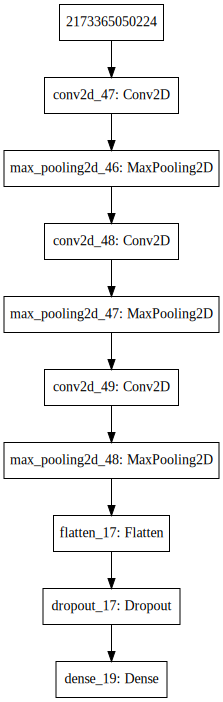

In [63]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [64]:
EPOCHS = 40
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 384 samples, validate on 216 samples
Epoch 1/40
384/384 [==============================] - 5s 12ms/step - loss: 1.7970 - acc: 0.1875 - val_loss: 1.6849 - val_acc: 0.2546
Epoch 2/40
384/384 [==============================] - 3s 7ms/step - loss: 1.6614 - acc: 0.2656 - val_loss: 1.5492 - val_acc: 0.5694
Epoch 3/40
384/384 [==============================] - 3s 8ms/step - loss: 1.4894 - acc: 0.4375 - val_loss: 1.3724 - val_acc: 0.6343
Epoch 4/40
384/384 [==============================] - 3s 8ms/step - loss: 1.3486 - acc: 0.5104 - val_loss: 1.2037 - val_acc: 0.6667
Epoch 5/40
384/384 [==============================] - 3s 8ms/step - loss: 1.1756 - acc: 0.5703 - val_loss: 1.0799 - val_acc: 0.6806
Epoch 6/40
384/384 [==============================] - 3s 8ms/step - loss: 1.1037 - acc: 0.5833 - val_loss: 0.9636 - val_acc: 0.7083
Epoch 7/40
384/384 [==============================] - 3s 8ms/step - loss: 1.0188 - acc: 0.6120 - val_loss: 0.8919 - val_acc: 0.6898
Epoch 8/40
384/384 [=========

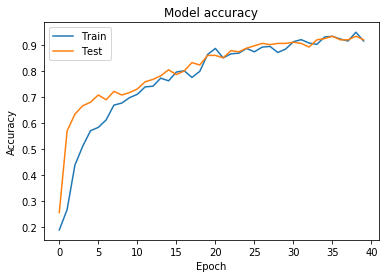

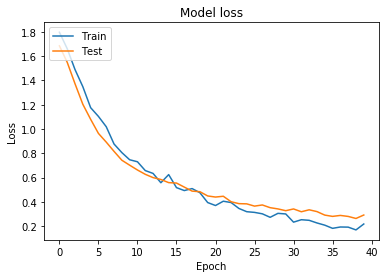

In [65]:
%run history.py
%matplotlib inline

plot_accuracy(history)
plot_loss(history)

## Save the model

In [67]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = DATASET_FOLDER + '/cnn_for_aed_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [68]:
del model
model = models.load_model(filename)

## Confirmation

In [69]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(384, 64, 40, 1)

In [70]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [71]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [72]:
class_labels

['piano',
 'classical_guitar',
 'framenco_guitar',
 'blues_harp',
 'tin_whistle',
 'silence']

In [73]:
(activations[-1][:10]*100).astype(int)

array([[ 0,  0,  0,  1,  0, 98],
       [ 0,  0,  0,  0,  0, 99],
       [ 0,  0,  0,  0,  0, 99],
       [34, 63,  0,  1,  0,  0],
       [ 0, 86, 10,  1,  0,  0],
       [ 0,  1, 93,  4,  0,  0],
       [ 0, 88,  9,  2,  0,  0],
       [ 0,  0,  0,  0,  0, 99],
       [ 0,  0,  0,  0,  0, 99],
       [ 0,  0,  0,  0,  0, 99]])

In [74]:
test_labels[:10].astype(int)

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [79]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(np.rot90(activations[layer][sample, :, :, i]))
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'classical_guitar'

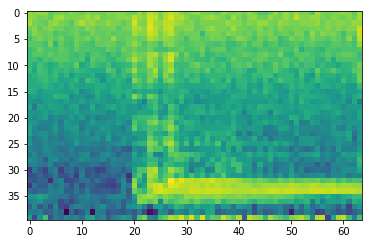

In [82]:
image_number = 29

plt.imshow(np.rot90(test_data[image_number,:,:,0]))
class_labels[np.argmax(test_labels[image_number])]

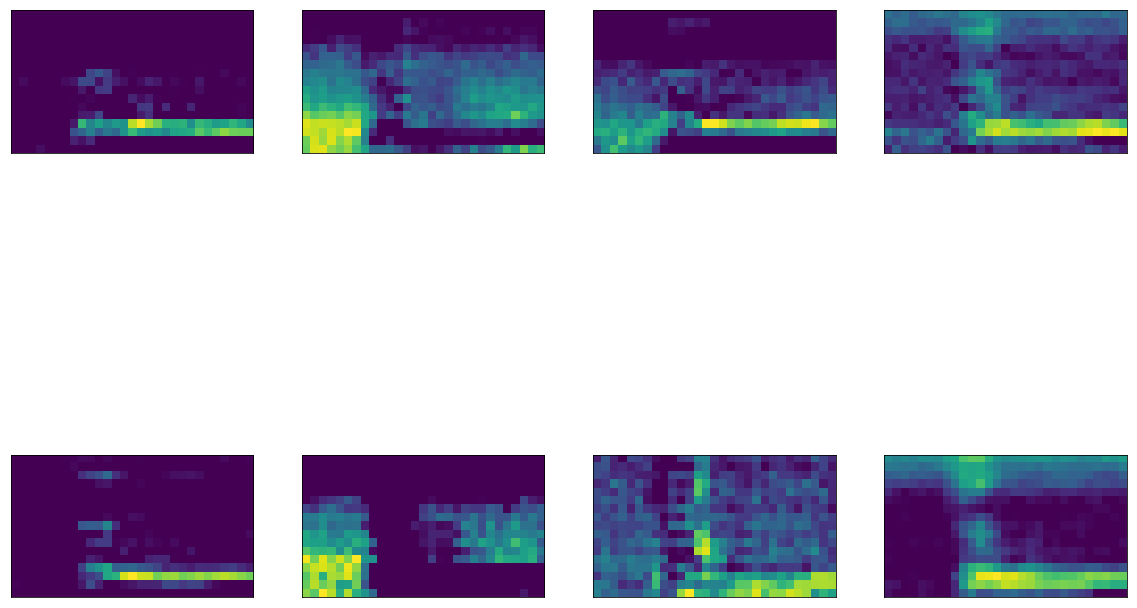

In [83]:
plot_layer(activations, image_number, 2)

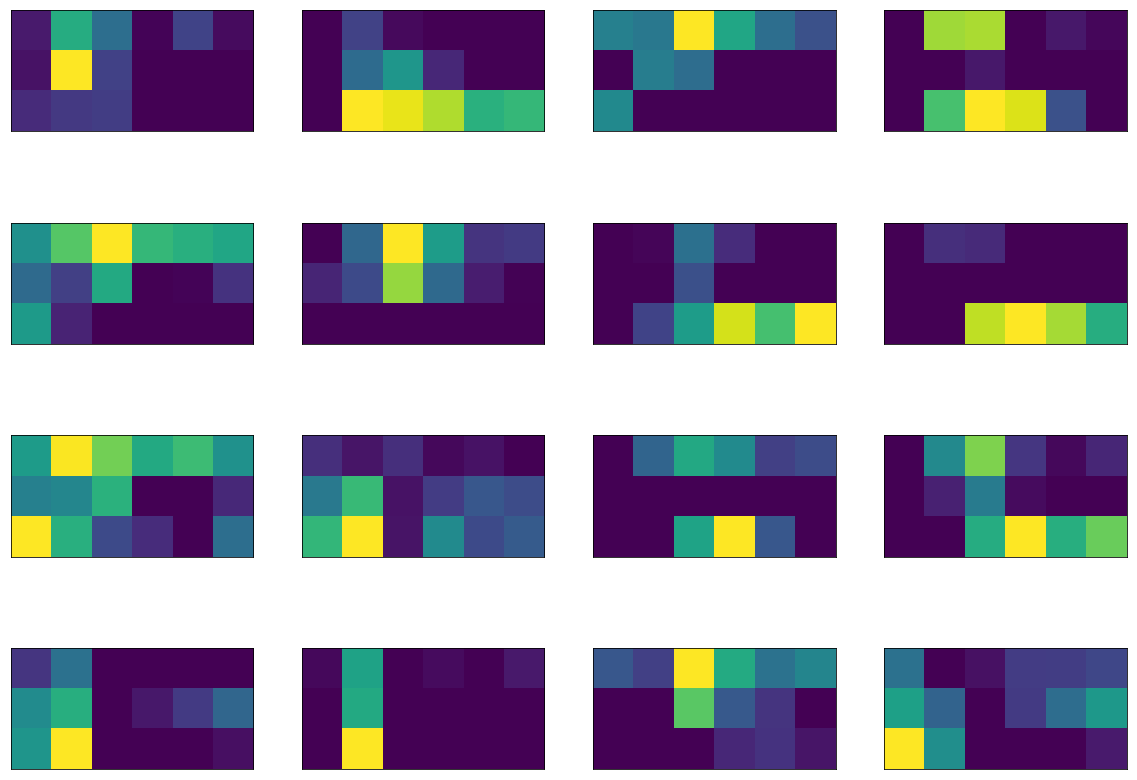

In [84]:
plot_layer(activations, image_number, 5)